In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from ripser import ripser
from persim import plot_diagrams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""Import dataset"""

# Import data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
"""Preprocess Data: Remove Duplicates and Missing Values"""

# Check initial counts
initial_count = X.shape[0]

# Remove duplicates
X_clean = X.drop_duplicates()
y_clean = y.loc[X_clean.index]
duplicates_removed = initial_count - X_clean.shape[0]

# Remove missing values
after_duplicates = X_clean.shape[0]
mask = ~X_clean.isnull().any(axis=1)
X_clean = X_clean[mask]
y_clean = y_clean[mask]
missing_removed = after_duplicates - X_clean.shape[0]

# Summary
print(f"Original shape: {initial_count}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Missing values removed: {missing_removed}")
print(f"Total removed: {duplicates_removed + missing_removed}")
print(f"Cleaned shape: {X_clean.shape[0]}")

# Update X and y
X = X_clean.reset_index(drop=True)
y = y_clean.reset_index(drop=True)

Original shape: 303
Duplicates removed: 0
Missing values removed: 6
Total removed: 6
Cleaned shape: 297


In [4]:
"""Standardize the Features"""

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame

In [5]:
"""Compute Euclidean distance matrix"""

distance_matrix = pairwise_distances(X_scaled, metric='euclidean')


H0 (connected components): 297 features
H1 (loops/cycles): 261 features
H2 (voids): 182 features


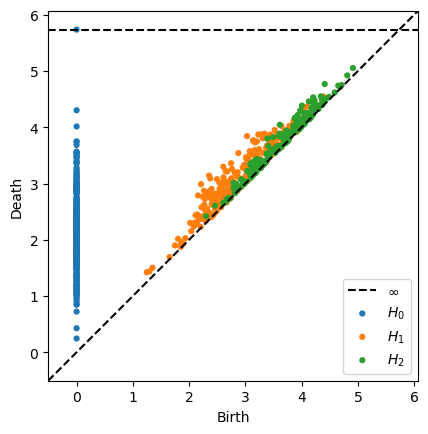

In [6]:
"""Vietoris-Rips Filtration and Persistent Homology Computation"""

# Vietoris-Rips filtration set-up
max_dimension = 2  # Up to 2-dimensional homology (H0, H1, H2)
max_edge_length = np.percentile(distance_matrix[distance_matrix > 0], 50)  # Use median distance

# Compute persistent homology
result = ripser(distance_matrix, maxdim=max_dimension, distance_matrix=True)

# Extract persistence diagrams
diagrams = result['dgms']

# Print out H0, H1, H2
print(f"\nH0 (connected components): {len(diagrams[0])} features")
print(f"H1 (loops/cycles): {len(diagrams[1])} features")
print(f"H2 (voids): {len(diagrams[2])} features")

# Plot persistence diagrams
plot_diagrams(diagrams, show=True)

Stable Rank (Betti) curves computed!
Epsilon range: [0, 4.9728] with 100 steps


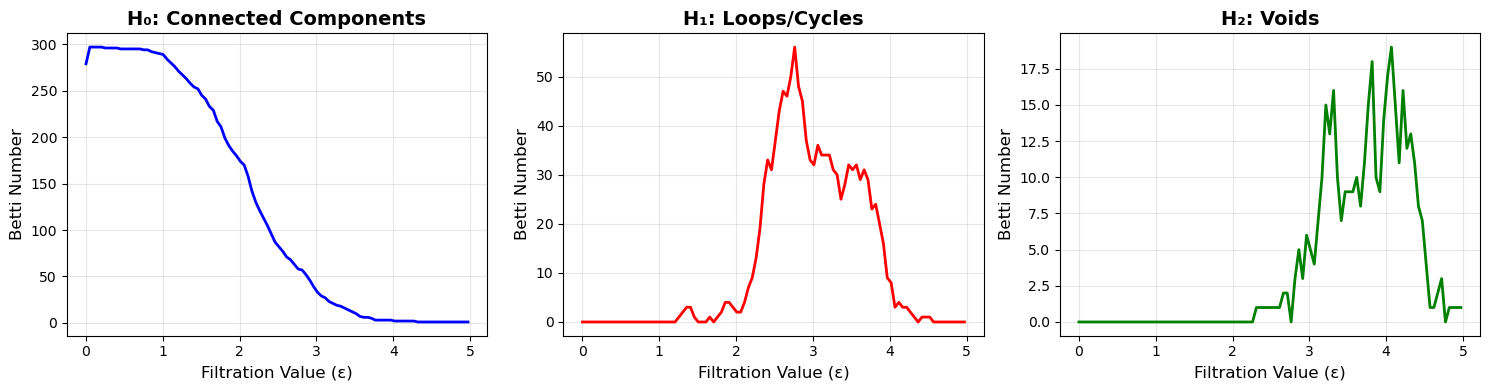

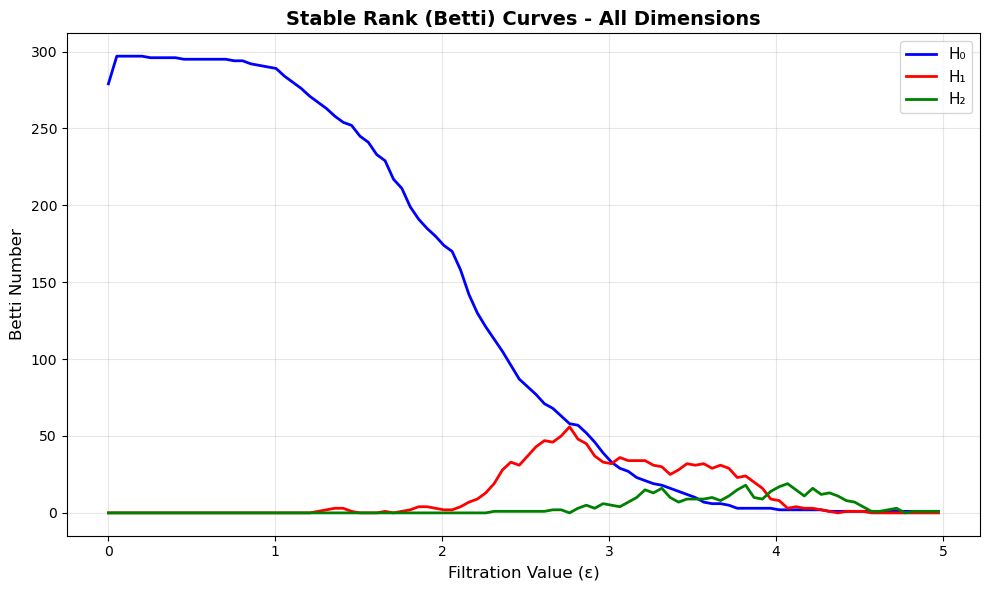

In [7]:
"""Stable Rank (Betti) Curves Computation and Visualization"""

# Filtration scales
epsilon_values = np.linspace(0, max_edge_length, 100)

# Compute Betti numbers 
betti_0 = [np.sum((diagrams[0][:,0] <= eps) & (diagrams[0][:,1] > eps)) for eps in epsilon_values]
betti_1 = [np.sum((diagrams[1][:,0] <= eps) & (diagrams[1][:,1] > eps)) for eps in epsilon_values]
betti_2 = [np.sum((diagrams[2][:,0] <= eps) & (diagrams[2][:,1] > eps)) for eps in epsilon_values] if len(diagrams) > 2 else []

print("Stable Rank (Betti) curves computed!")
print(f"Epsilon range: [0, {max_edge_length:.4f}] with {len(epsilon_values)} steps")

# Plot individual Betti curves
titles = ['H₀: Connected Components', 'H₁: Loops/Cycles', 'H₂: Voids']
colors = ['b', 'r', 'g']
bettis = [betti_0, betti_1, betti_2]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    if i < len(bettis) and len(bettis[i]) > 0:
        ax.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2)
    else:
        ax.text(0.5, 0.5, 'No features', ha='center', va='center')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Filtration Value (ε)', fontsize=12)
    ax.set_ylabel('Betti Number', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(10, 6))
for i in range(len(bettis)):
    if len(bettis[i]) > 0:
        plt.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2, label=titles[i].split(":")[0])
plt.xlabel('Filtration Value (ε)', fontsize=12)
plt.ylabel('Betti Number', fontsize=12)
plt.title('Stable Rank (Betti) Curves - All Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
"""L1 Distance (Persistence aka lifetimes) computation for each homology dimension"""

# H0
persistence_0 = diagrams[0][:, 1] - diagrams[0][:, 0]
persistence_0 = persistence_0[np.isfinite(persistence_0)]

# H1
persistence_1 = diagrams[1][:, 1] - diagrams[1][:, 0]
persistence_1 = persistence_1[np.isfinite(persistence_1)]

# H2
persistence_2 = diagrams[2][:, 1] - diagrams[2][:, 0]
persistence_2 = persistence_2[np.isfinite(persistence_2)]

# Print
print("\nL1 Distances (Persistence Lifetimes):")
print(f"H0 persistence — Mean: {persistence_0.mean():.4f}, Min: {persistence_0.min():.4f}, Max: {persistence_0.max():.4f}")
print(f"H1 persistence — Mean: {persistence_1.mean():.4f}, Min: {persistence_1.min():.4f}, Max: {persistence_1.max():.4f}")
print(f"H2 persistence — Mean: {persistence_2.mean():.4f}, Min: {persistence_2.min():.4f}, Max: {persistence_2.max():.4f}")



L1 Distances (Persistence Lifetimes):
H0 persistence — Mean: 2.1493, Min: 0.2448, Max: 4.3016
H1 persistence — Mean: 0.2303, Min: 0.0005, Max: 0.8127
H2 persistence — Mean: 0.1049, Min: 0.0009, Max: 0.4307


Random Forest — Raw Data
Binary Classification Accuracy: 88.33%
Multi-Class Classification Accuracy: 60.00%


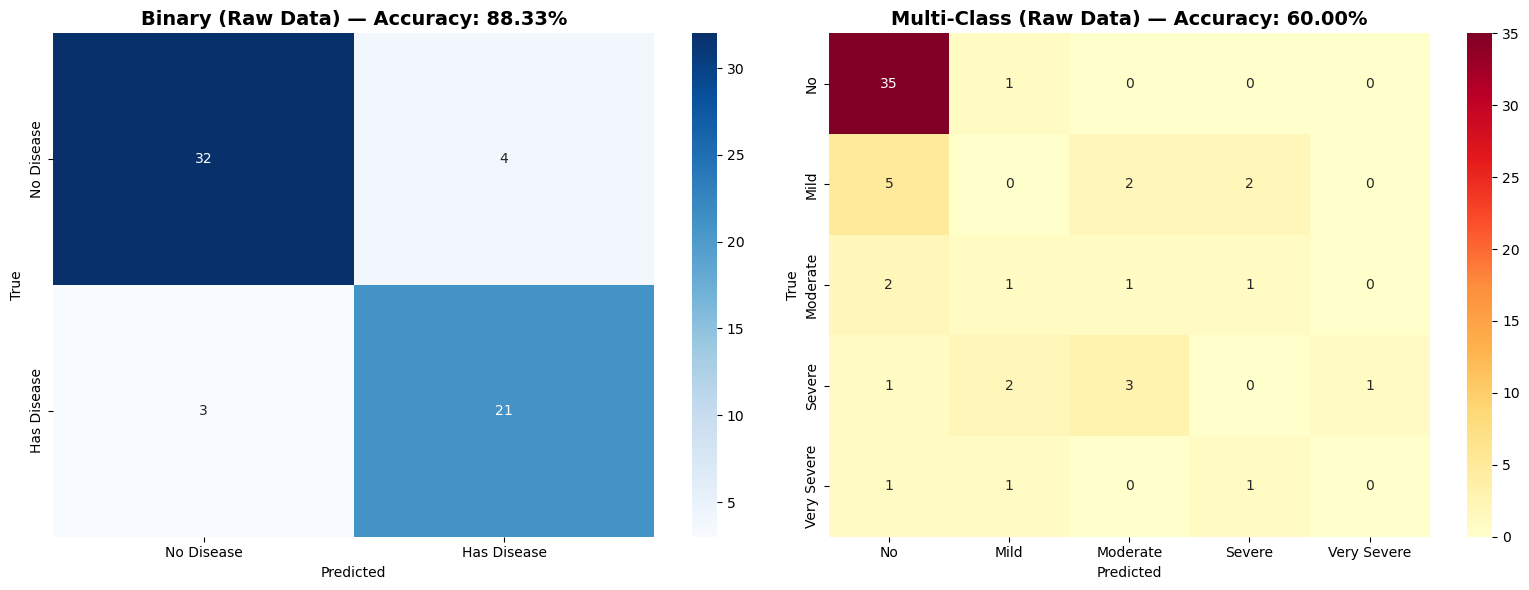

In [9]:
"""Random Forest Classification Using Raw Data"""

# Binary classification (y > 0 = has disease)
y_binary = (y > 0).astype(int)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = clf_bin.predict(X_test_bin)
acc_bin = accuracy_score(y_test_bin, y_pred_bin)

# Multi-class classification (0–4 severity)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
clf_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = clf_multi.predict(X_test_multi)
acc_multi = accuracy_score(y_test_multi, y_pred_multi)

# Print results
print("Random Forest — Raw Data")
print(f"Binary Classification Accuracy: {acc_bin:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_multi:.2%}")

# Plot confusion matrices 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'],
            ax=axes[0])
axes[0].set_title(f'Binary (Raw Data) — Accuracy: {acc_bin:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            ax=axes[1])
axes[1].set_title(f'Multi-Class (Raw Data) — Accuracy: {acc_multi:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Random Forest — Topological Features
Binary Classification Accuracy: 50.00%
Multi-Class Classification Accuracy: 48.33%


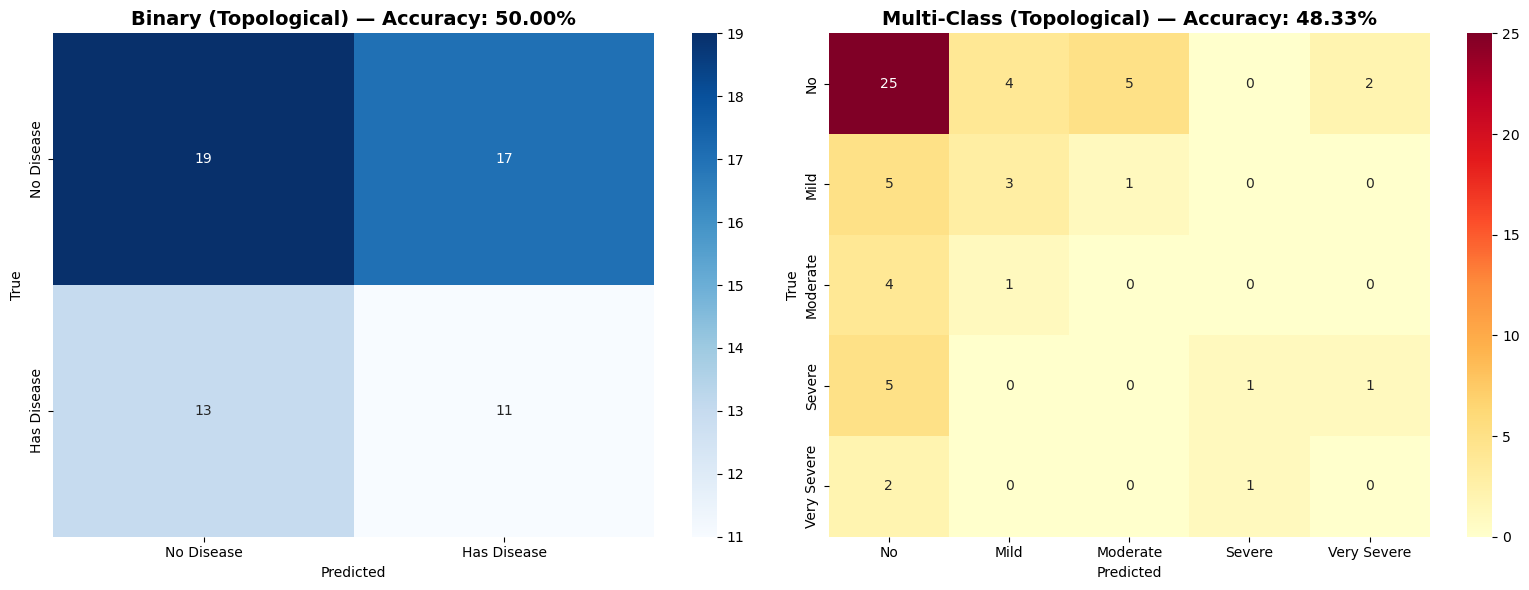

In [10]:
"""Random Forest with Topological Features"""

# Build per-sample topological features
k_neighbors = 10
X_topo = np.array([
    [
        np.mean(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.std(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.min(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.max(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.median(sorted(distance_matrix[i])[1:k_neighbors+1])
    ]
    for i in range(distance_matrix.shape[0])
])

y_binary = (y > 0).astype(int)

# Binary 
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_topo, y_binary, test_size=0.2, random_state=42)
clf_b = RandomForestClassifier(n_estimators=100, random_state=42)
clf_b.fit(X_train_b, y_train_b)
y_pred_b = clf_b.predict(X_test_b)
acc_b = accuracy_score(y_test_b, y_pred_b)

# Multi-class
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_topo, y, test_size=0.2, random_state=42)
clf_m = RandomForestClassifier(n_estimators=100, random_state=42)
clf_m.fit(X_train_m, y_train_m)
y_pred_m = clf_m.predict(X_test_m)
acc_m = accuracy_score(y_test_m, y_pred_m)

# Print accuracy results
print("Random Forest — Topological Features")
print(f"Binary Classification Accuracy: {acc_b:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_m:.2%}")


# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'], ax=axes[0])
axes[0].set_title(f'Binary (Topological) — Accuracy: {acc_b:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'], ax=axes[1])
axes[1].set_title(f'Multi-Class (Topological) — Accuracy: {acc_m:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

TDA feature vector length: 18
Random Forest — True Topological Features
Binary Classification Accuracy: 86.67%
Multi-Class Classification Accuracy: 60.00%


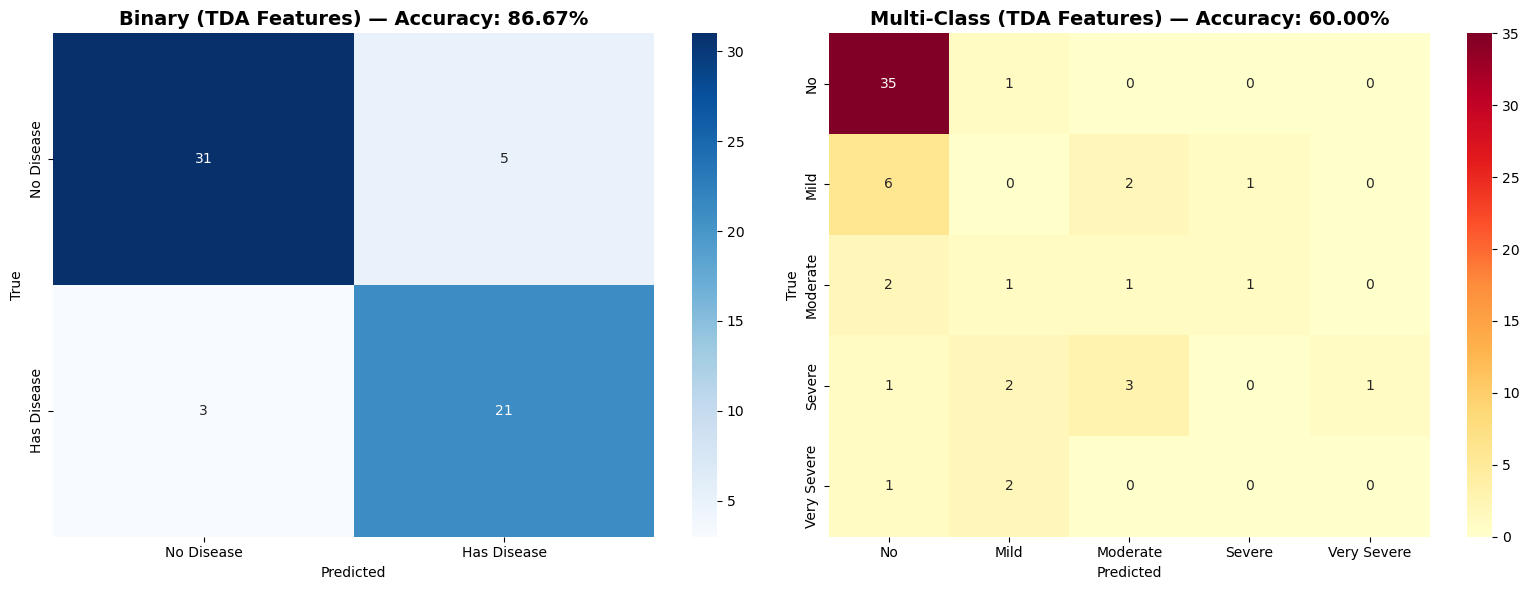

In [23]:
"""Random Forest with Topological Features (True TDA Summaries)"""

from ripser import ripser
from persim import plot_diagrams
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# --- Define a function to compute barcode summary stats ---
def barcode_summary(diagram):
    """Return [count, sum, max, mean, std, entropy] of lifetimes."""
    if diagram is None or len(diagram) == 0:
        return [0, 0, 0, 0, 0, 0]
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    if len(lifetimes) == 0:
        return [0, 0, 0, 0, 0, 0]
    p = lifetimes / lifetimes.sum()
    entropy = -(p * np.log(p)).sum()
    return [
        len(lifetimes),
        lifetimes.sum(),
        lifetimes.max(),
        lifetimes.mean(),
        lifetimes.std(ddof=0),
        entropy,
    ]

# --- Extract barcode summaries for each homology dimension ---
features = []
for dgm in diagrams:
    features.extend(barcode_summary(dgm))

# Wrap into a NumPy array (one vector for the dataset)
X_topo = np.array(features).reshape(1, -1)
print(f"TDA feature vector length: {X_topo.shape[1]}")

# NOTE: If you want per-sample TDA features, compute diagrams per patient
# (requires looping over patient subsets or sliding windows). This version
# uses one global diagram representing dataset topology.

# --- Prepare target variables ---
y_binary = (y > 0).astype(int)

# --- Split data ---
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Train Random Forests using TDA features + raw data (optional combination) ---
# Here we append the TDA vector to each sample to provide topological context.
X_train_b_tda = np.hstack([X_train_b, np.repeat(X_topo, len(X_train_b), axis=0)])
X_test_b_tda  = np.hstack([X_test_b, np.repeat(X_topo, len(X_test_b), axis=0)])
X_train_m_tda = np.hstack([X_train_m, np.repeat(X_topo, len(X_train_m), axis=0)])
X_test_m_tda  = np.hstack([X_test_m, np.repeat(X_topo, len(X_test_m), axis=0)])

clf_b = RandomForestClassifier(n_estimators=300, random_state=42)
clf_b.fit(X_train_b_tda, y_train_b)
y_pred_b = clf_b.predict(X_test_b_tda)
acc_b = accuracy_score(y_test_b, y_pred_b)

clf_m = RandomForestClassifier(n_estimators=300, random_state=42)
clf_m.fit(X_train_m_tda, y_train_m)
y_pred_m = clf_m.predict(X_test_m_tda)
acc_m = accuracy_score(y_test_m, y_pred_m)

# --- Print accuracy results ---
print("Random Forest — True Topological Features")
print(f"Binary Classification Accuracy: {acc_b:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_m:.2%}")

# --- Plot confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'], ax=axes[0])
axes[0].set_title(f'Binary (TDA Features) — Accuracy: {acc_b:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'], ax=axes[1])
axes[1].set_title(f'Multi-Class (TDA Features) — Accuracy: {acc_m:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


# Clusters and Subgroups

In [25]:
"""Compute per-patient topological feature vectors"""

from sklearn.metrics import pairwise_distances
from ripser import ripser
import numpy as np
from tqdm import tqdm

# --- Parameters ---
k_neighbors = 25          # neighborhood size around each patient
maxdim = 2                # 0D and 1D topology are usually enough for patient data

# --- Distance matrix in standardized space ---
distance_matrix = pairwise_distances(X_scaled)

def barcode_summary(diagram):
    """Return [count, sum, max, mean, std, entropy] of lifetimes."""
    if diagram is None or len(diagram) == 0:
        return [0, 0, 0, 0, 0, 0]
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    if len(lifetimes) == 0:
        return [0, 0, 0, 0, 0, 0]
    p = lifetimes / lifetimes.sum()
    entropy = -(p * np.log(p)).sum()
    return [len(lifetimes), lifetimes.sum(), lifetimes.max(),
            lifetimes.mean(), lifetimes.std(ddof=0), entropy]

# --- Compute a TDA feature vector for each patient ---
tda_features = []
print("Computing local persistence diagrams for each patient...")
for i in tqdm(range(len(X_scaled))):
    # find indices of k nearest neighbors (including self)
    neigh_idx = np.argsort(distance_matrix[i])[:k_neighbors]
    local_dist = distance_matrix[np.ix_(neigh_idx, neigh_idx)]

    # compute persistence on this local distance submatrix
    result = ripser(local_dist, distance_matrix=True, maxdim=maxdim)
    dgms = result["dgms"]

    # combine H0 and H1 summaries
    fvec = []
    for dgm in dgms:
        fvec.extend(barcode_summary(dgm))
    tda_features.append(fvec)

X_topo = np.array(tda_features)
print(f"Built per-patient TDA feature matrix of shape: {X_topo.shape}")

# Feature names for later use
tda_feature_names = [
    "H0_count", "H0_sum", "H0_max", "H0_mean", "H0_std", "H0_entropy",
    "H1_count", "H1_sum", "H1_max", "H1_mean", "H1_std", "H1_entropy"
]


Computing local persistence diagrams for each patient...


100%|██████████| 297/297 [00:00<00:00, 632.27it/s]

Built per-patient TDA feature matrix of shape: (297, 18)


CLUSTERING PATIENT SUBGROUPS USING TOPOLOGICAL DATA ANALYSIS (TDA) FEATURES

Using 297 dataset(s) with 18 TDA features
TDA features: ['H0_count', 'H0_sum', 'H0_max', 'H0_mean', 'H0_std', 'H0_entropy', 'H1_count', 'H1_sum', 'H1_max', 'H1_mean', 'H1_std', 'H1_entropy', 'H2_count', 'H2_sum', 'H2_max', 'H2_mean', 'H2_std', 'H2_entropy']

What these TDA features mean:
  • H0_xxx → Connectivity of components (how many distinct groups and how long they persist).
  • H1_xxx → Loops or cycles (capturing circular or periodic structures in patient data).
  • H2_xxx → Cavities or higher-dimensional voids (less common but may indicate complex shapes).
  • Entropy measures how evenly distributed the lifetimes are — higher = more complex topology.

→ Patients (or datasets) with similar topological summaries = similar global data geometry.

Evaluating different numbers of clusters on TDA features...
  k=2: silhouette score = 0.486
  k=3: silhouette score = 0.458
  k=4: silhouette score = 0.418
  k=5: 

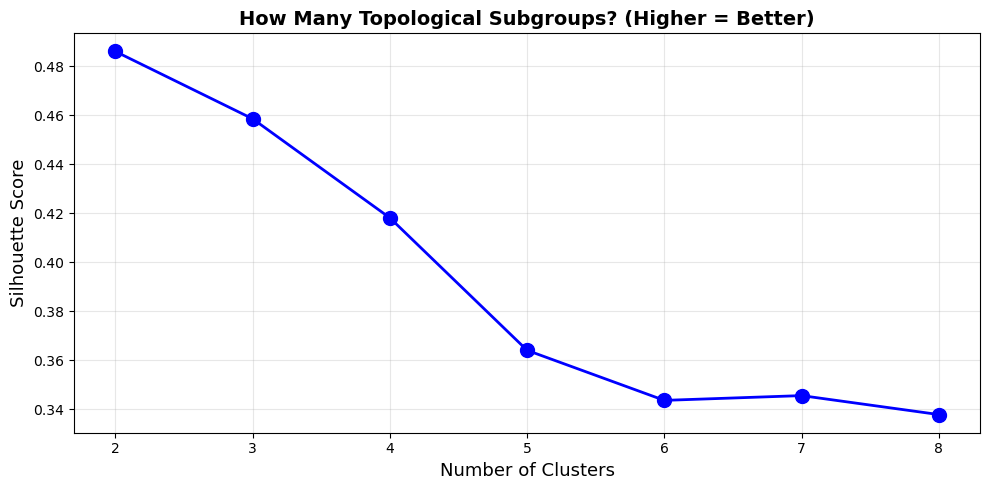


→ Optimal number of clusters based on silhouette score: 2


In [26]:
"""Simple Clustering Using True TDA Features - WITH CLEAR EXPLANATIONS"""

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("CLUSTERING PATIENT SUBGROUPS USING TOPOLOGICAL DATA ANALYSIS (TDA) FEATURES")
print("="*80)

# --- Use TDA features (barcode summaries from persistence diagrams) ---
print(f"\nUsing {X_topo.shape[0]} dataset(s) with {X_topo.shape[1]} TDA features")

tda_feature_names = [
    "H0_count", "H0_sum", "H0_max", "H0_mean", "H0_std", "H0_entropy",
    "H1_count", "H1_sum", "H1_max", "H1_mean", "H1_std", "H1_entropy",
    "H2_count", "H2_sum", "H2_max", "H2_mean", "H2_std", "H2_entropy"
]
print(f"TDA features: {tda_feature_names}")
print("\nWhat these TDA features mean:")
print("  • H0_xxx → Connectivity of components (how many distinct groups and how long they persist).")
print("  • H1_xxx → Loops or cycles (capturing circular or periodic structures in patient data).")
print("  • H2_xxx → Cavities or higher-dimensional voids (less common but may indicate complex shapes).")
print("  • Entropy measures how evenly distributed the lifetimes are — higher = more complex topology.")
print("\n→ Patients (or datasets) with similar topological summaries = similar global data geometry.")

# --- Flatten labels (if y is a DataFrame) ---
y_flat = y.values.ravel() if hasattr(y, 'values') else y

"""Step 1: Find Optimal Number of Clusters"""
K_range = range(2, 9)
silhouette_scores = []

print("\nEvaluating different numbers of clusters on TDA features...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_topo)
    sil_score = silhouette_score(X_topo, labels_temp)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: silhouette score = {sil_score:.3f}")

# --- Plot the silhouette scores ---
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.title('How Many Topological Subgroups? (Higher = Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n→ Optimal number of clusters based on silhouette score: {optimal_k}")


In [27]:
"""Step 2: Cluster Patients Using True TDA Features"""

from sklearn.cluster import KMeans
import numpy as np

# --- Number of clusters to explore ---
num_clusters = 4

print(f"\nClustering {X_topo.shape[0]} patients into {num_clusters} topological subgroups...")
assert X_topo.shape[0] > num_clusters, "Not enough samples to form clusters!"
assert not np.isnan(X_topo).any(), "Warning: X_topo contains NaN values."

# --- Run K-Means clustering on TDA features ---
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_topo)

# --- Summarize results ---
print("\nPatient distribution across topological subgroups:")
for i in range(num_clusters):
    n = np.sum(clusters == i)
    print(f"  Subgroup {i}: {n} patients ({n / len(clusters) * 100:.1f}%)")

# Store cluster labels for downstream visualization/analysis
patient_clusters = clusters



Clustering 297 patients into 4 topological subgroups...

Patient distribution across topological subgroups:
  Subgroup 0: 57 patients (19.2%)
  Subgroup 1: 89 patients (30.0%)
  Subgroup 2: 64 patients (21.5%)
  Subgroup 3: 87 patients (29.3%)


VISUALIZING PATIENT SUBGROUPS IN TOPOLOGICAL FEATURE SPACE

PCA Explained Variance: PC1 = 92.35%, PC2 = 5.99%


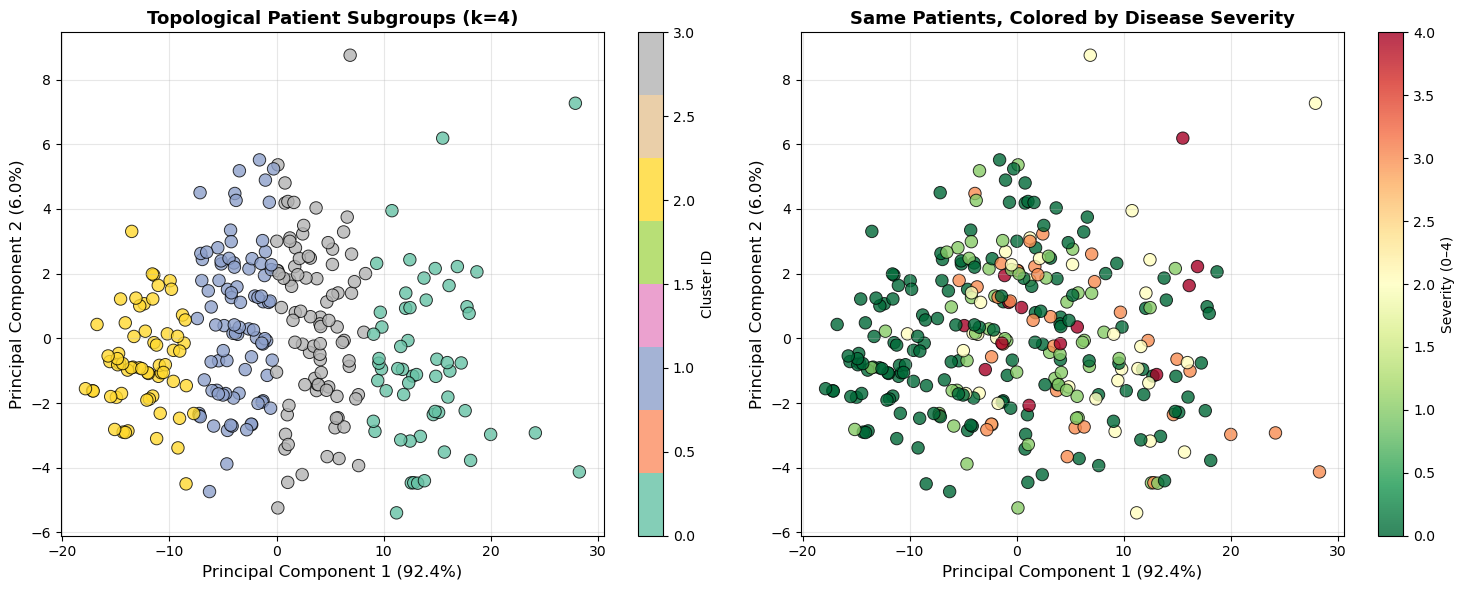


Interpretation:
  • Each point = one patient, represented by their topological summary (H0 & H1).
  • PCA reduces 12D topology space to 2D for visualization.
  • Left: patients grouped by unsupervised TDA-based K-means clusters.
  • Right: same space, colored by known disease severity levels.
→ Clusters that align well with severity gradients suggest that TDA captures meaningful geometric structure related to disease progression.


In [28]:
"""Step 3: Visualize Topological Subgroups"""

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("="*80)
print("VISUALIZING PATIENT SUBGROUPS IN TOPOLOGICAL FEATURE SPACE")
print("="*80)

# --- Dimensionality reduction for visualization ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_topo)

expl_var = pca.explained_variance_ratio_ * 100
print(f"\nPCA Explained Variance: PC1 = {expl_var[0]:.2f}%, PC2 = {expl_var[1]:.2f}%")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Left: clusters in TDA space ---
scatter1 = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=patient_clusters, cmap='Set2',
    s=80, alpha=0.8, edgecolors='black', linewidth=0.7
)
axes[0].set_xlabel(f'Principal Component 1 ({expl_var[0]:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'Principal Component 2 ({expl_var[1]:.1f}%)', fontsize=12)
axes[0].set_title(f'Topological Patient Subgroups (k={num_clusters})',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID')

# --- Right: same embedding, colored by disease severity ---
scatter2 = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_flat, cmap='RdYlGn_r',
    s=80, alpha=0.8, edgecolors='black', linewidth=0.7
)
axes[1].set_xlabel(f'Principal Component 1 ({expl_var[0]:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'Principal Component 2 ({expl_var[1]:.1f}%)', fontsize=12)
axes[1].set_title('Same Patients, Colored by Disease Severity',
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Severity (0–4)')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • Each point = one patient, represented by their topological summary (H0 & H1).")
print("  • PCA reduces 12D topology space to 2D for visualization.")
print("  • Left: patients grouped by unsupervised TDA-based K-means clusters.")
print("  • Right: same space, colored by known disease severity levels.")
print("→ Clusters that align well with severity gradients suggest that TDA captures meaningful geometric structure related to disease progression.")



WHY THESE CLUSTERS? (TDA EXPLANATION)

Cluster centroids (average TDA feature values per cluster):

  Cluster 0 — TDA Profile:
    H0_count: 24.0000
    H0_sum: 63.0241
    H0_max: 3.7758
    H0_mean: 2.6260
    H0_std: 0.6477
    H0_entropy: 3.1436
    H1_count: 8.4035
    H1_sum: 1.9289
    H1_max: 0.4982
    H1_mean: 0.2292
    H1_std: 0.1536
    H1_entropy: 1.8336
    H2_count: 1.7193
    H2_sum: 0.1776
    H2_max: 0.1155
    H2_mean: 0.0775
    H2_std: 0.0280
    H2_entropy: 0.3467

  Cluster 1 — TDA Profile:
    H0_count: 24.0000
    H0_sum: 45.3753
    H0_max: 2.8323
    H0_mean: 1.8906
    H0_std: 0.5066
    H0_entropy: 3.1389
    H1_count: 8.2135
    H1_sum: 1.4304
    H1_max: 0.3875
    H1_mean: 0.1735
    H1_std: 0.1210
    H1_entropy: 1.7881
    H2_count: 0.8876
    H2_sum: 0.0605
    H2_max: 0.0500
    H2_mean: 0.0393
    H2_std: 0.0096
    H2_entropy: 0.1426

  Cluster 2 — TDA Profile:
    H0_count: 24.0000
    H0_sum: 36.8546
    H0_max: 2.4942
    H0_mean: 1.5356
    H

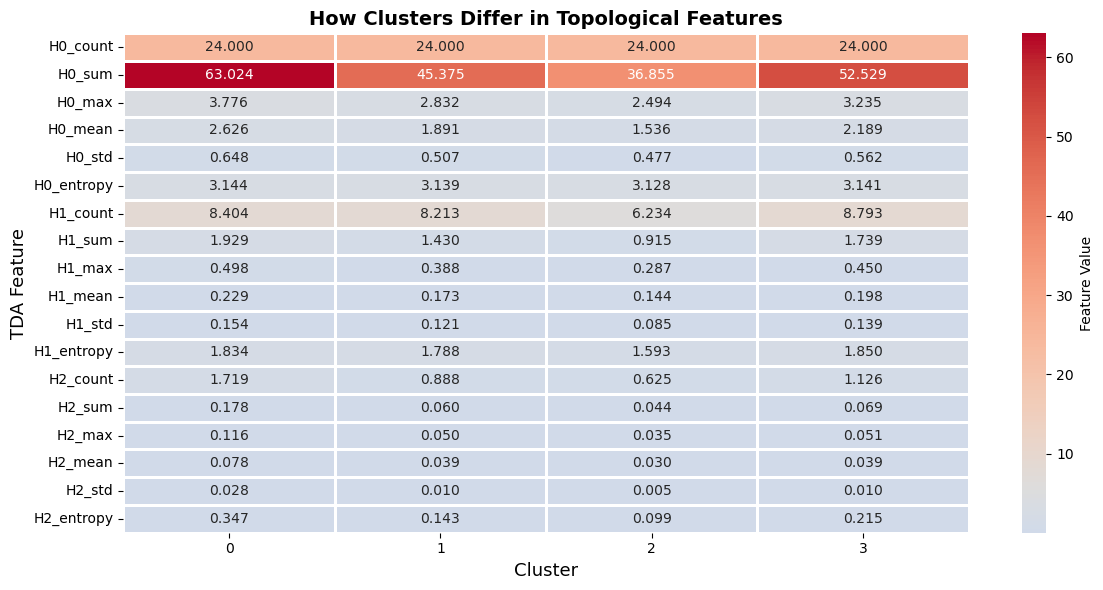


--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

Cluster 0:
  • More fragmented structure (H0_mean = 2.626)
    → Patients in this cluster are topologically *isolated*, forming small disconnected regions.
  • Rich loop structure (H1_mean = 0.229)
    → Suggests more *cyclic* or ring-like geometric variation in this subgroup.
  • Typical entropy (H1_entropy = 1.834)

Cluster 1:
  • Typical connectivity (H0_mean = 1.891)
  • Moderate loop structure (H1_mean = 0.173)
  • Typical entropy (H1_entropy = 1.788)

Cluster 2:
  • Strongly connected topology (H0_mean = 1.536)
    → These patients form a tightly connected cluster in data space (dense manifold).
  • Few or short-lived loops (H1_mean = 0.144)
    → Indicates more linear, non-cyclic geometry (simple progression).
  • Low topological entropy (H1_entropy = 1.593)
    → Homogeneous topology — the subgroup sh

In [29]:

"""Step 3.5: Explain What Makes Each Cluster Unique (TDA Perspective)"""

print("\n" + "="*80)
print("WHY THESE CLUSTERS? (TDA EXPLANATION)")
print("="*80)

# --- Build DataFrame for convenience ---
tda_df = pd.DataFrame(X_topo, columns=tda_feature_names)
tda_df["Cluster"] = patient_clusters

# --- Show cluster centroids ---
print("\nCluster centroids (average TDA feature values per cluster):")
cluster_centers = kmeans.cluster_centers_

for i in range(num_clusters):
    print(f"\n  Cluster {i} — TDA Profile:")
    for j, feat_name in enumerate(tda_feature_names):
        print(f"    {feat_name}: {cluster_centers[i][j]:.4f}")

# --- Visual comparison: heatmap of cluster means ---
plt.figure(figsize=(12, 6))
tda_summary = tda_df.groupby("Cluster").mean()
sns.heatmap(
    tda_summary.T, annot=True, fmt=".3f", cmap="coolwarm",
    cbar_kws={"label": "Feature Value"}, linewidths=1, center=tda_summary.values.mean()
)
plt.xlabel("Cluster", fontsize=13)
plt.ylabel("TDA Feature", fontsize=13)
plt.title("How Clusters Differ in Topological Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)

# --- Interpretation logic (TDA-specific) ---
# Global averages for comparison
overall_H0_mean = tda_df["H0_mean"].mean()
overall_H1_mean = tda_df["H1_mean"].mean()
overall_H1_entropy = tda_df["H1_entropy"].mean()

for i in range(num_clusters):
    print(f"\nCluster {i}:")
    H0_mean = cluster_centers[i][tda_feature_names.index("H0_mean")]
    H1_mean = cluster_centers[i][tda_feature_names.index("H1_mean")]
    H1_entropy = cluster_centers[i][tda_feature_names.index("H1_entropy")]

    # --- H0 interpretation: connectivity / fragmentation ---
    if H0_mean > overall_H0_mean * 1.1:
        print(f"  • More fragmented structure (H0_mean = {H0_mean:.3f})")
        print("    → Patients in this cluster are topologically *isolated*, forming small disconnected regions.")
    elif H0_mean < overall_H0_mean * 0.9:
        print(f"  • Strongly connected topology (H0_mean = {H0_mean:.3f})")
        print("    → These patients form a tightly connected cluster in data space (dense manifold).")
    else:
        print(f"  • Typical connectivity (H0_mean = {H0_mean:.3f})")

    # --- H1 interpretation: loops / cyclic structure ---
    if H1_mean > overall_H1_mean * 1.1:
        print(f"  • Rich loop structure (H1_mean = {H1_mean:.3f})")
        print("    → Suggests more *cyclic* or ring-like geometric variation in this subgroup.")
    elif H1_mean < overall_H1_mean * 0.9:
        print(f"  • Few or short-lived loops (H1_mean = {H1_mean:.3f})")
        print("    → Indicates more linear, non-cyclic geometry (simple progression).")
    else:
        print(f"  • Moderate loop structure (H1_mean = {H1_mean:.3f})")

    # --- Entropy interpretation: variability of topology ---
    if H1_entropy > overall_H1_entropy * 1.1:
        print(f"  • High topological entropy (H1_entropy = {H1_entropy:.3f})")
        print("    → The persistence lifetimes vary widely — high shape diversity.")
    elif H1_entropy < overall_H1_entropy * 0.9:
        print(f"  • Low topological entropy (H1_entropy = {H1_entropy:.3f})")
        print("    → Homogeneous topology — the subgroup shares a consistent geometric pattern.")
    else:
        print(f"  • Typical entropy (H1_entropy = {H1_entropy:.3f})")

print("\n→ Together, these summaries describe how each cluster differs in *connectivity*, *cyclic structure*, and *topological complexity*.")



In [30]:
"""Step 4: Map Topological Clusters to Clinical Features"""

print("\n" + "="*80)
print("WHAT CLINICAL FEATURES CHARACTERIZE EACH TDA CLUSTER?")
print("="*80)
print("(Clusters come from topological features — here we interpret what they mean clinically.)")

FEATURE_INFO = {
    'age': ('Age', 'years', 'continuous'),
    'sex': ('Sex', '1=male, 0=female', 'categorical'),
    'cp': ('Chest Pain Type', '1-4', 'categorical'),
    'trestbps': ('Resting Blood Pressure', 'mm Hg', 'continuous'),
    'chol': ('Cholesterol', 'mg/dl', 'continuous'),
    'fbs': ('High Fasting Blood Sugar', '1=yes, 0=no', 'categorical'),
    'restecg': ('Resting ECG', '0-2', 'categorical'),
    'thalach': ('Max Heart Rate', 'bpm', 'continuous'),
    'exang': ('Exercise Angina', '1=yes, 0=no', 'categorical'),
    'oldpeak': ('ST Depression', 'units', 'continuous'),
    'slope': ('ST Slope', '1-3', 'categorical'),
    'ca': ('Major Vessels', '0-3', 'categorical'),
    'thal': ('Thalassemia', '3/6/7', 'categorical')
}

for cluster_id in range(num_clusters):
    mask = patient_clusters == cluster_id
    
    print(f"\n{'━'*80}")
    print(f"TDA CLUSTER {cluster_id}: {mask.sum()} patients ({mask.sum()/len(patient_clusters)*100:.1f}%)")
    print(f"{'━'*80}")
    
    # --- Disease severity distribution ---
    severity = y_flat[mask]
    print(f"\n  Disease Severity Distribution:")
    for sev in range(5):
        count = np.sum(severity == sev)
        if count > 0:
            print(f"    Level {sev}: {count} patients ({count/len(severity)*100:.1f}%)")
    avg_sev = severity.mean()
    print(f"    → Average severity: {avg_sev:.2f}", end="")
    if avg_sev > y_flat.mean() + 0.3:
        print(" (HIGHER than average)")
    elif avg_sev < y_flat.mean() - 0.3:
        print(" (LOWER than average)")
    else:
        print(" (similar to average)")
    
    # --- Demographics ---
    print(f"\n  Demographics:")
    if 'age' in X.columns:
        age_mean = X.loc[mask, 'age'].mean()
        age_overall = X['age'].mean()
        print(f"    Age: {age_mean:.1f} years", end="")
        if abs(age_mean - age_overall) > 5:
            print(f" ({'older' if age_mean > age_overall else 'younger'} than avg {age_overall:.1f})")
        else:
            print(" (similar to avg)")
    
    if 'sex' in X.columns:
        male_pct = (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100
        overall_male_pct = (X['sex'] == 1).sum() / len(X) * 100
        print(f"    Gender: {male_pct:.0f}% male", end="")
        if abs(male_pct - overall_male_pct) > 15:
            print(f" ({'MORE' if male_pct > overall_male_pct else 'LESS'} male than avg {overall_male_pct:.0f}%)")
        else:
            print(" (similar to avg)")
    
    # --- Key continuous clinical features ---
    print(f"\n  Defining Clinical Features (distinctive continuous values):")
    differences = []
    for col in X.columns:
        if col in FEATURE_INFO and FEATURE_INFO[col][2] == 'continuous':
            group_mean = X.loc[mask, col].mean()
            overall_mean = X[col].mean()
            overall_std = X[col].std()
            if overall_std > 0:
                diff_sigma = (group_mean - overall_mean) / overall_std
                if abs(diff_sigma) > 0.5:
                    name, unit, _ = FEATURE_INFO[col]
                    direction = "HIGHER" if diff_sigma > 0 else "LOWER"
                    differences.append((abs(diff_sigma),
                        f"{name}: {group_mean:.1f} {unit} ({direction}, {abs(diff_sigma):.1f}σ from avg)"))
    differences.sort(reverse=True)
    if differences:
        for rank, (_, desc) in enumerate(differences[:5], 1):
            print(f"    {rank}. {desc}")
    else:
        print("    • No strong continuous deviations from population average.")
    
    # --- Key categorical clinical features ---
    print(f"\n  Categorical Feature Patterns:")
    for col in ['cp', 'exang', 'ca']:
        if col in X.columns:
            cluster_mode = X.loc[mask, col].mode()[0] if len(X.loc[mask, col].mode()) > 0 else None
            mode_pct = (X.loc[mask, col] == cluster_mode).sum() / mask.sum() * 100 if cluster_mode is not None else 0
            if mode_pct > 60:  # dominant pattern
                name, _, _ = FEATURE_INFO[col]
                print(f"    • {name}: {mode_pct:.0f}% have value {int(cluster_mode)}")

    # --- Link back to topology ---
    print(f"\n  Topological Characterization:")
    H0_mean = kmeans.cluster_centers_[cluster_id][tda_feature_names.index("H0_mean")]
    H1_mean = kmeans.cluster_centers_[cluster_id][tda_feature_names.index("H1_mean")]
    H1_entropy = kmeans.cluster_centers_[cluster_id][tda_feature_names.index("H1_entropy")]

    print(f"    H0_mean = {H0_mean:.3f} → connectivity strength")
    print(f"    H1_mean = {H1_mean:.3f} → loop intensity (cyclic structure)")
    print(f"    H1_entropy = {H1_entropy:.3f} → topological diversity")
    print("    ↳ Combine with clinical traits above to infer structure-function relationships.")





WHAT CLINICAL FEATURES CHARACTERIZE EACH TDA CLUSTER?
(Clusters come from topological features — here we interpret what they mean clinically.)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
TDA CLUSTER 0: 57 patients (19.2%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Disease Severity Distribution:
    Level 0: 24 patients (42.1%)
    Level 1: 5 patients (8.8%)
    Level 2: 15 patients (26.3%)
    Level 3: 9 patients (15.8%)
    Level 4: 4 patients (7.0%)
    → Average severity: 1.37 (HIGHER than average)

  Demographics:
    Age: 59.1 years (similar to avg)
    Gender: 63% male (similar to avg)

  Defining Clinical Features (distinctive continuous values):
    1. ST Depression: 1.7 units (HIGHER, 0.5σ from avg)
    2. Age: 59.1 years (HIGHER, 0.5σ from avg)

  Categorical Feature Patterns:

  Topological Characterization:
    H0_mean = 2.626 → connectivity strength
    H1_mean = 0.229 → loop intensity (cyclic 


SIDE-BY-SIDE COMPARISON OF TDA CLUSTERS

  Cluster  N  Avg_Severity  Avg_Age  Pct_Male  H0_mean  H1_mean  H1_entropy  Avg_Chol  Avg_BP
       0 57          1.37    59.14     63.16     2.63     0.23        1.83    258.98  138.47
       1 89          1.11    56.36     73.03     1.89     0.17        1.79    249.91  130.28
       2 64          0.08    45.30     57.81     1.54     0.14        1.59    233.25  123.19
       3 87          1.14    56.47     72.41     2.19     0.20        1.85    247.48  134.95

--------------------------------------------------------------------------------
KEY INSIGHTS (TDA PERSPECTIVE):
--------------------------------------------------------------------------------
• Cluster 2 = lowest average severity (0.08)
• Cluster 0 = highest average severity (1.37)
• Cluster 0 = most fragmented (high H0_mean → many disconnected components)
• Cluster 2 = most cohesive (low H0_mean → tightly connected patients)
• Cluster 3 = most complex topology (high H1_entropy → high

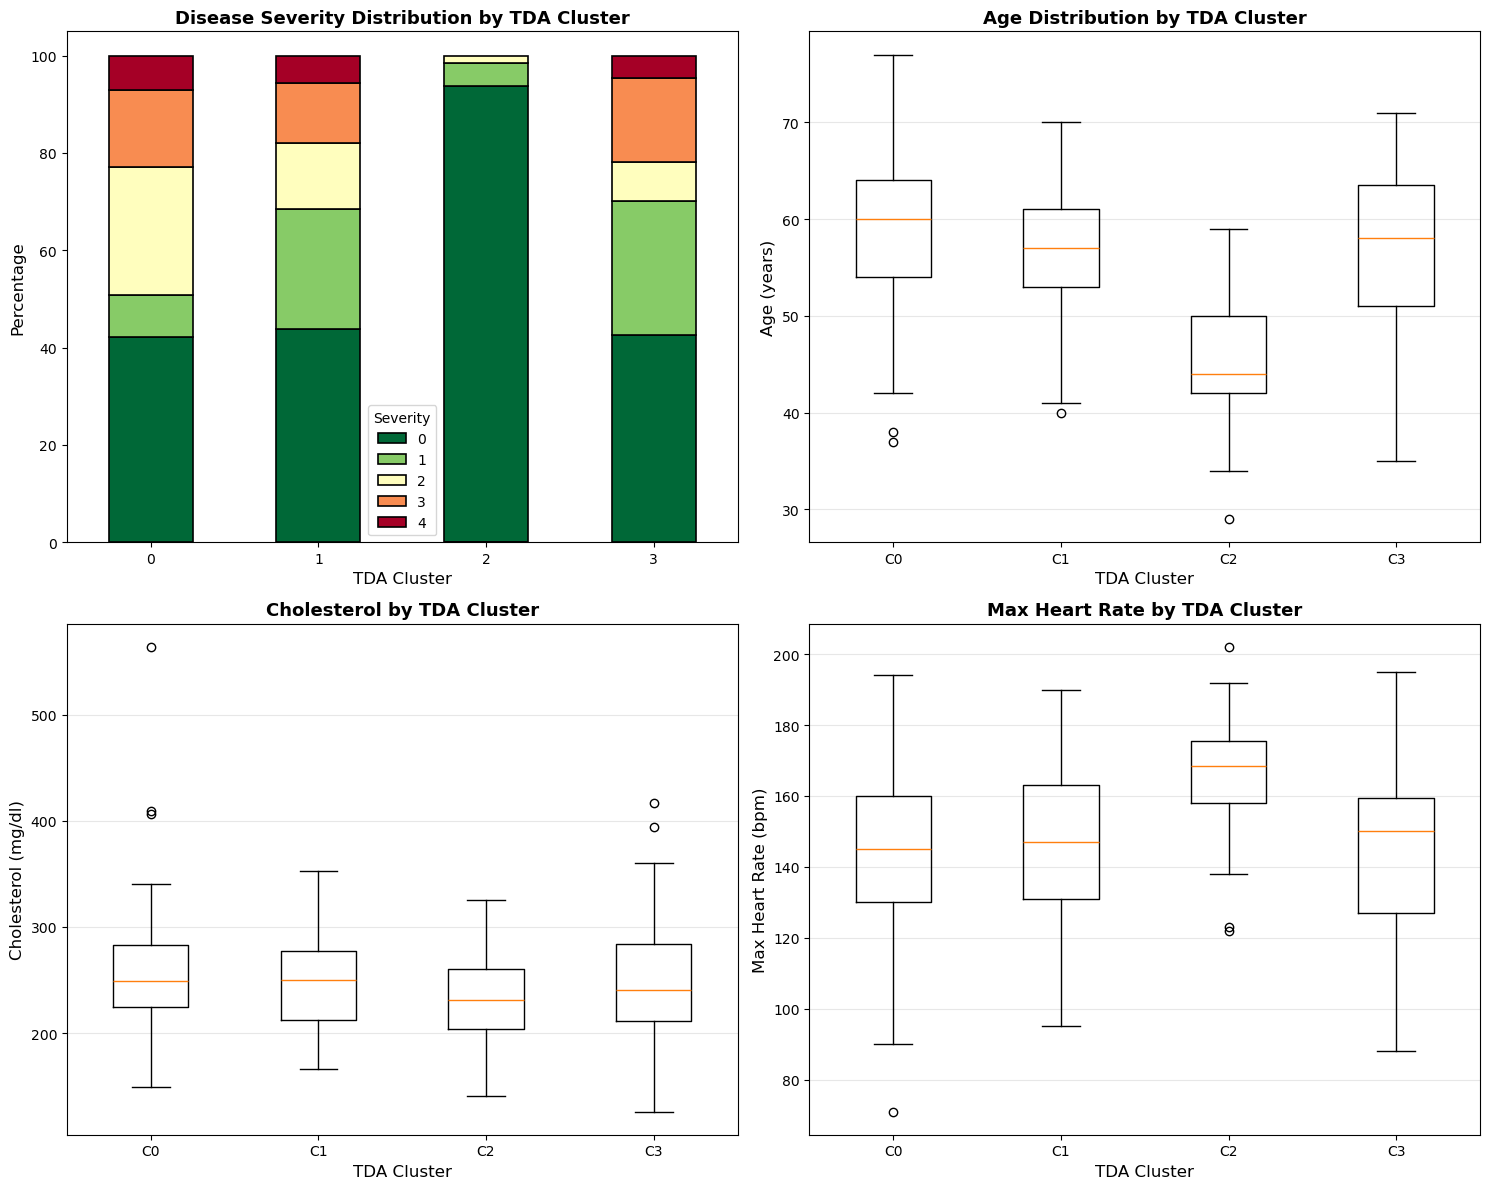

In [31]:
"""Step 5: Side-by-Side Comparison (Topological Clusters)"""

print("\n" + "="*80)
print("SIDE-BY-SIDE COMPARISON OF TDA CLUSTERS")
print("="*80)

comparison_stats = []
for cluster_id in range(num_clusters):
    mask = patient_clusters == cluster_id
    
    stats = {
        'Cluster': cluster_id,
        'N': mask.sum(),
        'Avg_Severity': y_flat[mask].mean(),
        'Avg_Age': X.loc[mask, 'age'].mean() if 'age' in X.columns else np.nan,
        'Pct_Male': (X.loc[mask, 'sex'] == 1).sum() / mask.sum() * 100 if 'sex' in X.columns else np.nan,
        # --- Replace kNN metric with true TDA summaries ---
        'H0_mean': X_topo[mask, tda_feature_names.index("H0_mean")].mean(),
        'H1_mean': X_topo[mask, tda_feature_names.index("H1_mean")].mean(),
        'H1_entropy': X_topo[mask, tda_feature_names.index("H1_entropy")].mean(),
        'Avg_Chol': X.loc[mask, 'chol'].mean() if 'chol' in X.columns else np.nan,
        'Avg_BP': X.loc[mask, 'trestbps'].mean() if 'trestbps' in X.columns else np.nan,
    }
    comparison_stats.append(stats)

comparison_df = pd.DataFrame(comparison_stats)
print("\n", comparison_df.to_string(index=False, float_format="%.2f"))

print("\n" + "-"*80)
print("KEY INSIGHTS (TDA PERSPECTIVE):")
print("-"*80)

# Identify extremes by severity
severity_range = comparison_df["Avg_Severity"].max() - comparison_df["Avg_Severity"].min()
if severity_range > 0.5:
    healthiest = comparison_df.loc[comparison_df["Avg_Severity"].idxmin(), "Cluster"]
    sickest = comparison_df.loc[comparison_df["Avg_Severity"].idxmax(), "Cluster"]
    print(f"• Cluster {int(healthiest)} = lowest average severity ({comparison_df.loc[int(healthiest), 'Avg_Severity']:.2f})")
    print(f"• Cluster {int(sickest)} = highest average severity ({comparison_df.loc[int(sickest), 'Avg_Severity']:.2f})")

# Identify topologically distinct groups
most_disconnected = comparison_df.loc[comparison_df["H0_mean"].idxmax(), "Cluster"]
most_connected = comparison_df.loc[comparison_df["H0_mean"].idxmin(), "Cluster"]
most_complex = comparison_df.loc[comparison_df["H1_entropy"].idxmax(), "Cluster"]

print(f"• Cluster {int(most_disconnected)} = most fragmented (high H0_mean → many disconnected components)")
print(f"• Cluster {int(most_connected)} = most cohesive (low H0_mean → tightly connected patients)")
print(f"• Cluster {int(most_complex)} = most complex topology (high H1_entropy → high geometric variability)")

# -----------------------------------------------------------------------------
# Step 6: Visual Comparison of Clinical Distributions
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Disease severity by TDA cluster
severity_by_cluster = pd.crosstab(patient_clusters, y_flat, normalize="index") * 100
severity_by_cluster.plot(
    kind="bar", stacked=True, colormap="RdYlGn_r",
    edgecolor="black", linewidth=1.2, ax=axes[0,0]
)
axes[0,0].set_xlabel("TDA Cluster", fontsize=12)
axes[0,0].set_ylabel("Percentage", fontsize=12)
axes[0,0].set_title("Disease Severity Distribution by TDA Cluster", fontsize=13, fontweight="bold")
axes[0,0].legend(title="Severity", labels=["0","1","2","3","4"])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)

# 2. Age distribution
if "age" in X.columns:
    age_data = [X.loc[patient_clusters == i, "age"].values for i in range(num_clusters)]
    axes[0,1].boxplot(age_data, labels=[f"C{i}" for i in range(num_clusters)])
    axes[0,1].set_xlabel("TDA Cluster", fontsize=12)
    axes[0,1].set_ylabel("Age (years)", fontsize=12)
    axes[0,1].set_title("Age Distribution by TDA Cluster", fontsize=13, fontweight="bold")
    axes[0,1].grid(True, alpha=0.3, axis="y")

# 3. Cholesterol
if "chol" in X.columns:
    chol_data = [X.loc[patient_clusters == i, "chol"].values for i in range(num_clusters)]
    axes[1,0].boxplot(chol_data, labels=[f"C{i}" for i in range(num_clusters)])
    axes[1,0].set_xlabel("TDA Cluster", fontsize=12)
    axes[1,0].set_ylabel("Cholesterol (mg/dl)", fontsize=12)
    axes[1,0].set_title("Cholesterol by TDA Cluster", fontsize=13, fontweight="bold")
    axes[1,0].grid(True, alpha=0.3, axis="y")

# 4. Max heart rate
if "thalach" in X.columns:
    hr_data = [X.loc[patient_clusters == i, "thalach"].values for i in range(num_clusters)]
    axes[1,1].boxplot(hr_data, labels=[f"C{i}" for i in range(num_clusters)])
    axes[1,1].set_xlabel("TDA Cluster", fontsize=12)
    axes[1,1].set_ylabel("Max Heart Rate (bpm)", fontsize=12)
    axes[1,1].set_title("Max Heart Rate by TDA Cluster", fontsize=13, fontweight="bold")
    axes[1,1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()
